In [2]:
!git clone https://github.com/pieper/dicomsort.git
!pip install pydicom
!python dicomsort/dicomsort.py --help

fatal: destination path 'dicomsort' already exists and is not an empty directory.

% dicomsort.py --help
dicomsort [options...] sourceDir targetDir/<patterns>

 where [options...] can be:
    [-z,--compressTargets] - create a .zip file in the target directory
    [-d,--deleteSource] - remove source files/directories after sorting
    [-f,--forceDelete] - remove source without confirmation
    [-k,--keepGoing] - report but ignore dupicate target files
    [-v,--verbose] - print diagnostics while processing
    [-s,--symlink] - create a symlink to dicom files in sourceDir instead of copying them
    [-t,--test] - run the built in self test (requires internet)
    [-u,--unsafe] - do not replace unsafe characters with '_' in the path
    [--help] - print this message

 where sourceDir is directory to be scanned or "" (null string) to read file list from stdin

 where targetDir/<patterns...> is a string defining the output file and directory
 names based on the dicom tags in the file.

If p

In [3]:
!pip install pylidc

In [4]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
pl.query(pl.Scan).count()


1018

In [6]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178'

In [7]:
myProjectID = "idc-external-012"

In [8]:
import os
data_folder = os.getcwd() + '/cohort_sorted_3/'
data_folder

'/home/jovyan/capstone/capstone/cohort_sorted_3/'

In [9]:
f = open ('.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

Current patient ID = LIDC-IDRI-0069
Loading dicom files ... This may take a moment.


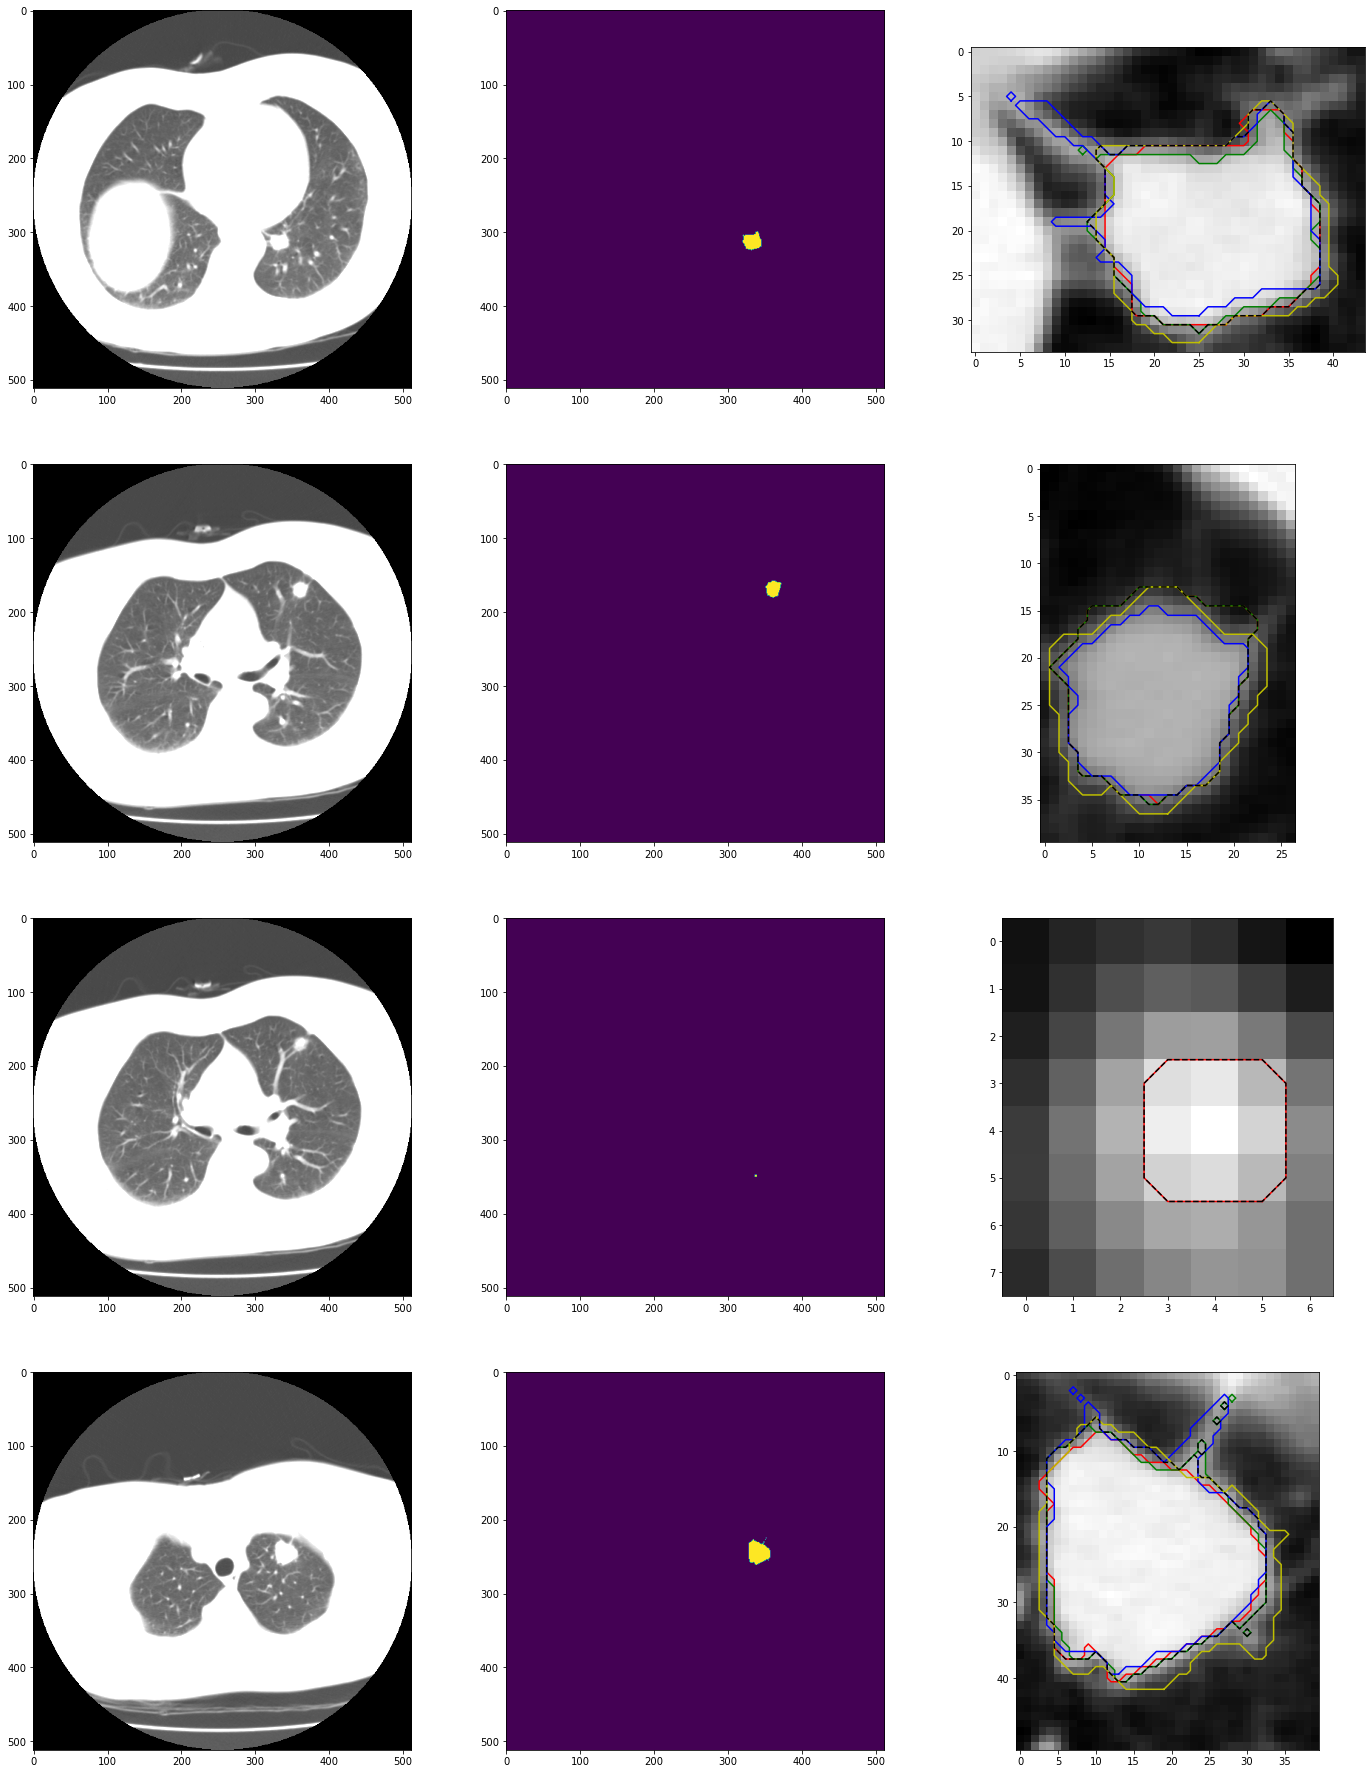

In [10]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

In [ ]:

CT_image_data = []
CT_mask_data  = []

for pa in range(len(patient_list)):
    print ("Current patient ID =", patient_list[pa])
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
    nodules_annotation = scan[pa].cluster_annotations()
    vol = scan[pa].to_volume()
    
    CT_image_data.append(vol)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask
        
    CT_mask_data.append(CT_mask)

Current patient ID = LIDC-IDRI-0069
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0078
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0094
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0095
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0098
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0101
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0298
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0300
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0314
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0325
Loading dicom files ... This may take a moment.


In [ ]:
import tensorflow as tf

In [ ]:
def normalize(input_image):#, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image#, input_mask

In [ ]:
def load_image(CT_image_data, CT_mask_data):
    #use nearest, to prevent the labels from changing
    input_image = CT_image_data#tf.image.resize(CT_image_data, (128, 128), method='nearest')
    #input_mask = tf.image.resize(CT_mask_data, (128, 128), method='nearest')
    input_mask = CT_mask_data#tf.image.resize(CT_mask_data, (128, 128), method='nearest')

    input_image = normalize(input_image)

    return input_image, input_mask

In [ ]:
inp, msk = load_image(CT_image_data[0], CT_mask_data[0])
print(inp.shape, msk.shape)

In [ ]:
# alternate, for more than one patient
# get the dataset generator
def get_train_data_generator_bodytext(CT_image_data, CT_mask_data):
    for i in range(len(CT_image_data)):
        for j in range(CT_image_data[i].shape[2]):
            image, mask = load_image(tf.expand_dims(CT_image_data[i][:,:,j], -1), tf.expand_dims(CT_mask_data[i][:,:,j], -1))
            yield image, tf.keras.utils.to_categorical(mask, num_classes=2)
        # yield image, mask
def get_train_dataset(CT_image_data, CT_mask_data):
    generator = lambda: get_train_data_generator_bodytext(CT_image_data, CT_mask_data)
    return tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(512, 512, 2), dtype=tf.float32)))

In [ ]:
ds_train = get_train_dataset(CT_image_data,CT_mask_data)
ds_train.element_spec

In [ ]:
ds_train = get_train_dataset(CT_image_data,CT_mask_data)
ds_train.element_spec

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print(display_list[i])
        plt.imshow(display_list[i])
        #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
for images, masks in ds_train.shuffle(300).take(5):
    sample_image, sample_mask = images[:,:,0], masks[:,:,0]
    display([sample_image, sample_mask])

In [ ]:
!pip install git+https://github.com/jakeret/unet.git

In [ ]:
import unet
from unet.datasets import circles

In [ ]:
LEARNING_RATE = 1e-3
unet_model = unet.build_model(channels=1,
                              num_classes=2,
                              layer_depth=2,
                              filters_root=64)
unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [ ]:
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)
trainer.fit(unet_model,
            ds_train,
            ds_train,
            epochs=25,
            batch_size=1)